## Module 2 Final Project Submission

Please fill out:
* Student name: Fahima Hyder
* Student pace:  Part Time
* Scheduled project review date/time: February 13, 2019. 6:30pm
* Instructor name: Jeff Herman
* Blog post URL: https://fhyder.github.io/module_2_final_project_the_n_justifies_the_means

In [1]:
import sqlite3 as sql
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()




For our first question we are testing if discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount? I will be testing the following hypotheses at a 5% alpha level. I will be performing a one-tailed T-test to test see if the mean of quantities ordered of discounted items is higher than the mean of quantites ordered of non-discounted items. In order to answer this question we will be working with the order details table. Lets first transfer the data from this table into a pandas DataFrame so we can have a nice view of what our dataset looks like.

In [3]:
order = pd.read_sql_query('SELECT * FROM OrderDetail', conn)

In [4]:
order.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


The variables that I will be working with in this hypothesis test will be Quantity at the no discount level and Quantity at discounted levels. Lets isolate these values

In [5]:
noDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = 0''').fetchall()
discounted = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount != 0''').fetchall()


Just as a preliminary step lets take a look at distplots to see if there are any noticeable differences in means

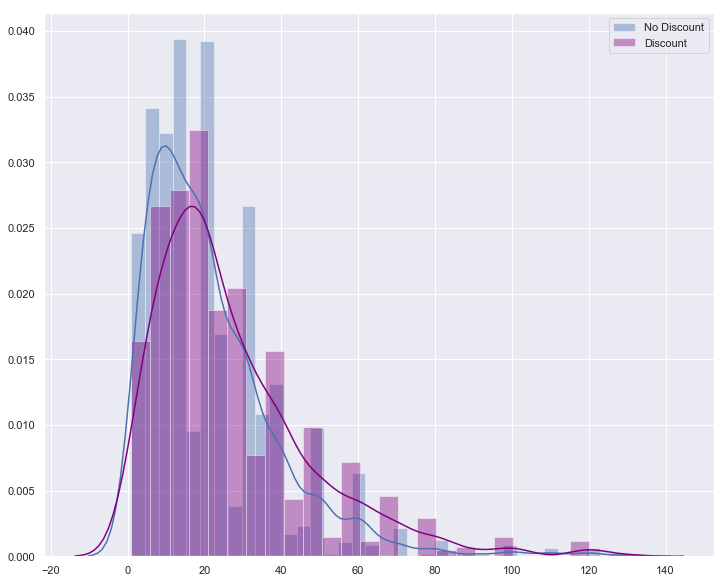

In [6]:
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(noDiscount, label = 'No Discount') # Blue distribution
sns.distplot(discounted,color='Purple', label = 'Discount') # Purple distribution
plt.legend()
plt.show()

Looking at this distplot, it looks like there are higher quantity instances for our discounted distribution. In order to avoid errors in our findings it's important to report on both the practical significance (effect size) and the statistical significance (P-values/T-test) of our tests. Since the question asks for statistical significance lets start there. This is a one-tailed test as we are testing if one mu is larger than the other.

## NULL HYPOTHESIS : Adding a discount to a product DOES NOT increase the average quantites ordered H0: μ = 21.72

## ALTERNATE : Adding a discount to a product DOES increase the average quantites ordered H0: μ > 21.72

## Significance level (alpha) : .05


First, I'll gather some necessary statistical data 

In [49]:
mu = np.mean(noDiscount) # what is our mu

sigma = np.std(noDiscount)

# Sample mean (x̄) 
x_bar= np.mean(discounted)

# Sample Stadrad Deviation (sigma) using Numpy
sigmaDisc = np.std(discounted)

# Sample size (n)
n = len(discounted)

# Degrees of Freedom
dof = n-1

# Difference in sample mean
diff = x_bar - mu

alpha = .05

print ('The discounted Quantities contain', n, 'observations, having a mean of', x_bar, "and a standard deviation = ", sigma,
       ", with", dof, 'degrees of freedom. The difference between sample and population means is:', diff)



The discounted Quantities contain 838 observations, having a mean of 27.10978520286396 and a standard deviation =  17.500845477669806 , with 837 degrees of freedom. The difference between sample and population means is: 5.394523243866239


The difference between discounted and non-discounted quantities is: 5.39. A positive difference indicates that there is an increase in the sample mean. Now I'll calculate the T-statistic and and compare it to the criticial-Tvalue to determine if this increase is high enough to reject the null hypothesis. In order to run this test I am assuming that my data is colleced randomly and is independent to the best of our knowledge. The assumption of a normal distribution is negligible for sample sizes > 30

Our Null hypothesis is only rejected if our T-stat is higher than the critical T-Value and our P-value is lower than the significance level, alpha

In [8]:
t = (x_bar -  mu)/(sigmaDisc/np.sqrt(n)) 

t_critical = stats.t.ppf(1-alpha, dof)
results = stats.ttest_1samp(discounted, mu)

#print("The t-value for sample is", results[0] , "and the p-value is", results[1], t) check statement

if (results[0] > t_critical) and (results[1] < .05):
    print ("Null hypothesis rejected. Results are statistically significant with t-value =",
    results[0], "critical t-value =", t_critical, "and p-value =", results[1])
else:
    print ("Failed to reject null hypothesis  with t-value =",
    [0], ", critical t-value =", t_critical, "and p-value =", results[1])
    



Null hypothesis rejected. Results are statistically significant with t-value = [7.51810676] critical t-value = 1.6466761685634412 and p-value = [1.43089923e-13]


Our tests finds that 95% of the time higher quantities are ordered for items with a discount. 

Now I know that there is a statistically significant increase on average of quantites ordered for discounted items. The simple effect size is denoted as the difference in means for the two distributions, which I previously found to be 5.3945. Now I will calculate Cohen's D to report the practical significance of our findings  

In [9]:
def Cohen_d(group1, group2):

    

    diff = np.mean(group1) - np.mean(group2)

    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)

   
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    
    d = diff / np.sqrt(pooled_var)
    
    return round(abs(d), 1)

In [10]:
Cohen_d(discounted, noDiscount)

0.3

So our Cohen's D of .3 shows that the means of our two groups differ by .3 standard deviations. According to Cohen's threshold, this is a small effect size, that is there is a practical significance in between our two group but that difference is, well, small. However, we can conclude that adding a discount has both a statistical and practical significance on the average quantities ordered. 

Let's also use an A/B test to determine if our sample size is approprate for reports devoid of Type 1 or Type 2 errors.

Alpha = .05

Beta = .2

In [11]:
def compute_n(alpha, beta, mu_0, mu_1, var):
    z_alpha = stats.norm.ppf(alpha)
    z_beta = stats.norm.ppf(beta)
    num = ((z_alpha+z_beta)**2)*var
    den = (mu_1 - mu_0)**2
    return num/den

alpha = .05 #Part of A/B test design
beta = .2 #Part of A/B test design
mu_0 = mu #Part of A/B test design
mu_1 = x_bar #Part of A/B test design
var = sigmaDisc**2 #sample variance

compute_n(alpha, beta, mu_0, mu_1, var), n



(91.55385301480129, 838)

The sample size of 838 is well above the proposed sample size of 91.55 and therefore results are reported with a high degree of confidence. That is our results will incur type 1 errors at a maximum rate of 5% and type 2 errors at a maximum rate of 20%

My t-test finds that the null hypothesis can be rejected. Now I will address the second part of the hypothesis and calculate at which levels of discount this significance occurs. First lets find which types of discounts are offered: 

In [12]:
order.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

We can see that the discounts offered are as follow: none, 1%, 2%, 3%, 4%, 5%, 6%, 10%, 15%, 20%, 25%. I will make arrays out of all of the quantity's ordered at each of these discount levels to use in my hypothesis tests.

In [13]:
noDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = 0''').fetchall()
oneDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .01''').fetchall()
twoDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .02''').fetchall()
threeDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .03''').fetchall()
fourDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .04''').fetchall()
fiveDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .05''').fetchall()
sixDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .06''').fetchall()
tenDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .1''').fetchall()
fifteenDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .15''').fetchall()
twentyDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .20''').fetchall()
twentyfiveDiscount = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount = .25''').fetchall()



I will observe the sample sizes at each discount level to evaluate if a t-test can be conducted. Sample sizes < 30 must display a normal distribution

In [14]:
discountsArray = [oneDiscount, twoDiscount, threeDiscount, fourDiscount, fiveDiscount, sixDiscount, tenDiscount, fifteenDiscount, twentyDiscount, twentyfiveDiscount]
for i in discountsArray:
    print(len(i))
    print('---------')

1
---------
2
---------
3
---------
1
---------
185
---------
1
---------
173
---------
157
---------
161
---------
154
---------


Discounts at the 1, 2, 3, 4, and 6 percent levels report quantities that are too small to report on. These discount levels will not be tested. I will create a function that will run the same t-test above on the remaining discount levels.

In [15]:
def oneSampleTest(sample, mu, alpha):
    x_bar= np.mean(sample)
    # Sample Standard Deviation (sigma) using Numpy
    sigma = np.std(sample)

    # Sample size (n)
    n = len(sample)

    # Degrees of Freedom
    dof = n-1

    # Difference in sample mean
    diff = x_bar - mu
    
    alpha = .05 #signficance level
    
    t = (x_bar -  mu)/(sigma/np.sqrt(n))
    t_critical = stats.t.ppf(1-alpha, dof)
    results = stats.ttest_1samp(sample, mu)
   
    if (abs(results[0]) > t_critical) and (results[1] < alpha):
        print ("Null hypothesis rejected. Results are statistically significant with t-value =", results[0], "critical t-value =", t_critical, "and p-value =", results[1])
    else:
        print ("We fail to reject the null hypothesis with t-value =", results[0],  ", critical t-value =", t_critical, "and p-value =", results[1])
    
    
    
   

In [16]:
discountsArray = [noDiscount, fiveDiscount, tenDiscount, fifteenDiscount, twentyDiscount, twentyfiveDiscount]
for i in discountsArray:
    oneSampleTest(i, mu = mu, alpha = .05)
    print(np.mean(i) - np.mean(noDiscount))
    print('-----------------------')

We fail to reject the null hypothesis with t-value = [0.] , critical t-value = 1.6460123267212001 and p-value = [1.]
0.0
-----------------------
Null hypothesis rejected. Results are statistically significant with t-value = [3.85929052] critical t-value = 1.6531770875301313 and p-value = [0.00015725]
6.295548851813088
-----------------------
Null hypothesis rejected. Results are statistically significant with t-value = [2.18635208] critical t-value = 1.6537609493607581 and p-value = [0.03014047]
3.521732260655458
-----------------------
Null hypothesis rejected. Results are statistically significant with t-value = [3.99252814] critical t-value = 1.6546799956696048 and p-value = [0.0001004]
6.666903646097818
-----------------------
Null hypothesis rejected. Results are statistically significant with t-value = [3.57732522] critical t-value = 1.6544329014554642 and p-value = [0.00045954]
5.309582761499172
-----------------------
Null hypothesis rejected. Results are statistically signific

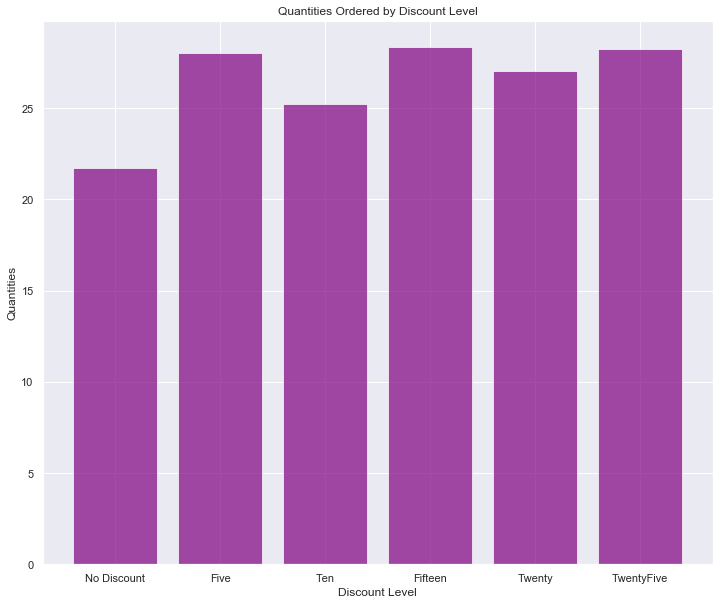

In [17]:
mns = []
xs = ['No Discount','Five', 'Ten', 'Fifteen', 'Twenty', 'TwentyFive']
for i in discountsArray:
    mns.append(np.mean(i))
plt.bar(xs, mns, align = 'center', alpha = .70, color = 'purple')
plt.ylabel('Quantities')
plt.title('Quantities Ordered by Discount Level')
plt.xlabel('Discount Level')


plt.show()

In [18]:
print(np.mean(fiveDiscount) - np.mean(noDiscount))
print(np.mean(fifteenDiscount) - np.mean(noDiscount))
print(np.mean(twentyfiveDiscount) - np.mean(noDiscount))

6.295548851813088
6.666903646097818
6.5249977812620195


Based on my findings above the discount levels that have statistical significance on quantity of products ordered is at the 5, 10, 15, 20, and 25%. If we judge based on difference in means, discounts at the five, fifteen, and twenty five level are pretty neck in neck. 


For my second hypothesis test I'm interested to know if price has an effect on quantities ordered for discounted items. My instinct tells me that if an item that is priced higher is offered at a discounted rate that item will be sold at larger quantities than lower priced items offered at a discounted rate

In [19]:
order.head()

    

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


To determine lower-priced items vs. higher priced items I'll take the median of unit price for items that are discounted. I'll then divide my group based on that number as follows

In [20]:
uP = cur.execute('''SELECT UnitPrice FROM OrderDetail WHERE Discount > 0 ''').fetchall()
np.median(uP)



18.0

In [21]:
higherpriced = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount > 0 AND UnitPrice > 17''').fetchall()
lowerpriced = cur.execute('''SELECT Quantity FROM OrderDetail WHERE Discount > 0  AND UnitPrice < 18''').fetchall()

For our second hypothesis test I will be testing at an alpha level of 5%. I will run a two-sample t-test to eliminiate one of the following. This is a two tailed test.

## NULL HYPOTHESIS: Mu Quantity (higherpriced) - Mu Quantity (lowerpriced) = 0

## ALTERNATE HYPOTHESS: Mu Quantity (higherpriced) - Mu Quantity(lowerpriced) != 0

First I'll evaluate the distribution plots for our two groups to get a visual idea of whether means are similar or different

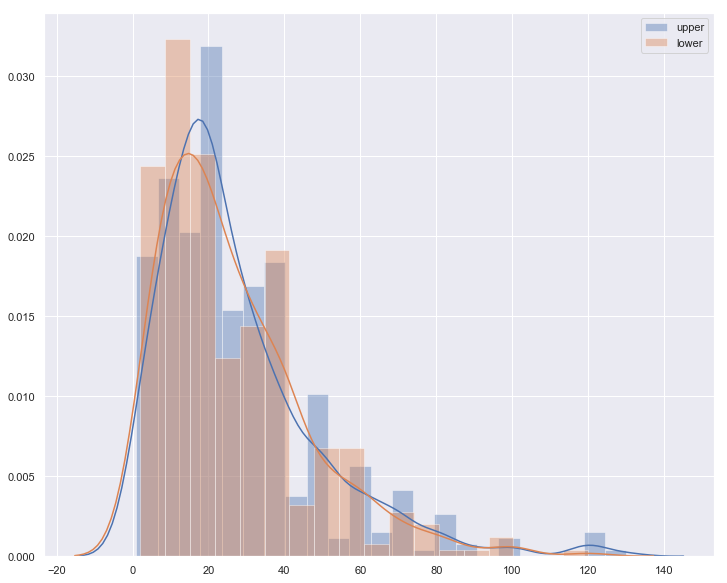

In [22]:
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(higherpriced, label = 'upper') # Blue distribution
sns.distplot(lowerpriced, label = 'lower') # Green distribution
plt.legend()
plt.show()

There's a lot of overlap here we'll calculate our t-statistic to find our p-value and compare it to our alpha of .05 to determine if we fail to reject our null hypothesis


In [23]:
alpha = .05
higherpricedmu = np.mean(higherpriced)
lowerpricedmu = np.mean(lowerpriced)

higherpricedvar = sum([(i - higherpricedmu)**2 for i in higherpriced])
lowerpricedvar = sum([(i - lowerpricedmu)**2 for i in lowerpriced])
n_higher = len(higherpriced)
n_lower = len(lowerpriced)
sample_var = (higherpricedvar + lowerpricedvar)/((n_higher + n_lower)-2)
top = higherpricedmu - lowerpricedmu
bottom = np.sqrt(sample_var * ((1/n_higher + (1/n_lower))))
t = top/bottom





Let's visualize our T_stat and -T-stats to identify our criticial boundaries

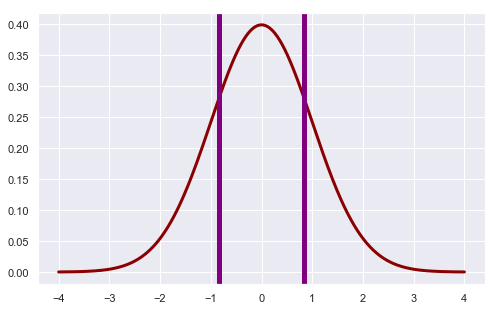

In [24]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='purple', linestyle='-', lw=5)
    ax.axvline(-t_stat, color='purple', linestyle='-', lw=5)

    plt.show()
    return None

n_control = len(higherpriced)
n_experimental = len(lowerpriced)
visualize_t(t, n_control, n_experimental)

The p-value is calculated as the area underneath this curve. We're gonna use SciPy's built in formula's to do it the easy way. Then we'll compare the p-value to our alpha of .05 to determine whether we should reject or null hypothesis or not.

In [25]:
p_val = stats.t.sf(abs(t), (n_higher + n_lower)-1) * 2


if p_val < alpha:
    print('Null hypothesis rejected. Results are statistically significant with a p_value of: ',p_val,', which is lower than our significance level of ', alpha)
else:
    print('Fail to reject Null Hypothesis. Results show a p_value of: ',p_val,', which is higher than our significance level of ', alpha)


Fail to reject Null Hypothesis. Results show a p_value of:  [0.40520511] , which is higher than our significance level of  0.05


We failed to reject our null hypothesis, price does not have a statistical effect on Quantities sold at a discounted level. This means that the business would benefit more by applying smaller discounts to their more expensive items. This way quantites sold are increased without critically comprimising profits accrued

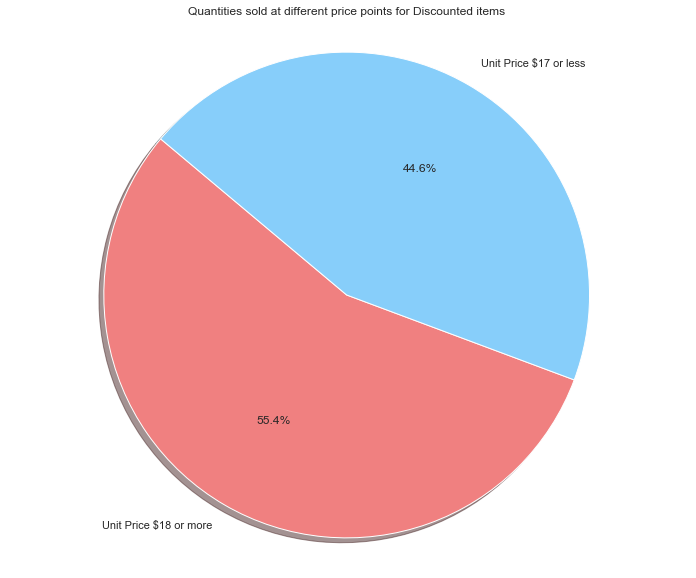

In [26]:
# Data to plot
labels = 'Unit Price $18 or more', 'Unit Price $17 or less'
sizes = [n_higher, n_lower]
colors = ['lightcoral', 'lightskyblue']

 
# Plot
plt.pie(sizes,  labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Quantities sold at different price points for Discounted items ')
plt.show()

For our third hypothesis I've noticed that some units are in stock at much higher quantites than others. Does this have something to do with the price? I will see if higher priced items tend to be in stock in larger quantites than lower priced items. The median of units in stock will serve as the threshold for determining if an item is in "High Stock" or "Low Stock". I will use a significance level of .05 to test the following. This is a one-tailed test as we are testing if one mu is larger than the other.

## NULL HYPOTHESIS: MU of UNIT PRICE of items in LOW STOCK < MU of UNIT PRICE of items in HIGH STOCK

## ALTERNATIVE HYPOTHESIS: MU of UNIT PRICE of items in LOW STOCK > MU of UNIT PRICE of items in HIGH STOCK

## Alpha: .05

This time I'll be using the Product table to access units in stock. 

In [27]:
unitsInStock = pd.read_sql_query('''SELECT * FROM Product''', conn)
unitsInStock.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Let's define items that are in High Stock to be items that are in stock of quantites of 100 or higher and low stock to be items in stock of quantites of 30 or lower

In [28]:
low_Stock = unitsInStock.loc[unitsInStock['UnitsInStock'] < 31] 
high_Stock = unitsInStock.loc[unitsInStock['UnitsInStock'] > 99] 

#lowStock.head()
#lowStock.UnitsInStock.unique()
#highStock.head()
#highStock.UnitsInStock.unique()

sample = low_Stock.UnitPrice
high_unit = high_Stock.UnitPrice
mu = np.mean(high_unit)
x_bar = np.mean(sample)
alpha = .05

In [29]:
oneSampleTest(sample, mu, alpha)

Null hypothesis rejected. Results are statistically significant with t-value = 2.5575149042902376 critical t-value = 1.6819523559426 and p-value = 0.014242098138597357


Interestingly enough, our null hypothesis is rejected, price does not have an effect on whether an item is being ordered or not. It seems that quality over quantity rules here. Let's look at Cohen's D to report the practical signficiance of our findings

In [30]:
Cohen_d(sample, high_unit)

0.4

Cohen's D shows us that there is a practical significance in our findings but that the effect size is small.

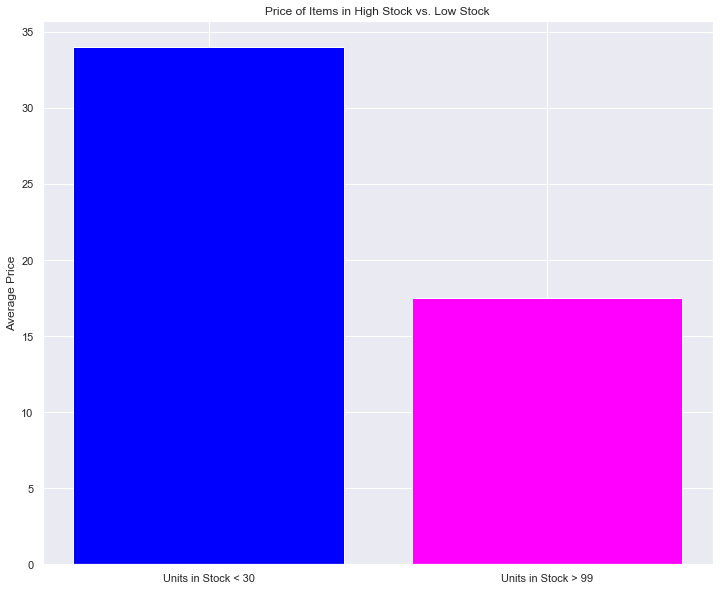

In [31]:

plt.figsize = (8,8)
colors = ['blue', 'magenta']
mns = [x_bar, mu]
xs = ['Units in Stock < 30', 'Units in Stock > 99']
plt.bar(xs, mns, align = 'center', color = colors)
plt.title('Price of Items in High Stock vs. Low Stock')
plt.ylabel('Average Price')




plt.show()

For our last hypothesis test, let's take a look at our customer base for the Northwind database and evaluate their buying habits by country. We'll be using the Customer and Order Details tables for this test. First lets isolate countries from the customer table

In [32]:
custdf = pd.read_sql_query('''SELECT Id,Country FROM Customer''', conn)

custdf.head()

,Id,Country
0,ALFKI,Germany
1,ANATR,Mexico
2,ANTON,Mexico
3,AROUT,UK
4,BERGS,Sweden


The schema shows that the Customer and Order Details table don't share a key. However, both tables share keys with the Order table. I'll be using the order table to create a dataframe which includes the Country a customer is from and quantities ordered. In order to avoid any confusion, I'll be changing the names of keys so that we can easily identify which table they've come from 

In [33]:
custdf.columns.values[0] = 'CID'

In [34]:
orderdf = pd.read_sql_query('''SELECT Id, CustomerId FROM [Order]''', conn)
orderdf.head()


,Id,CustomerId
0,10248,VINET
1,10249,TOMSP
2,10250,HANAR
3,10251,VICTE
4,10252,SUPRD


In [35]:
orderdf.columns.values[0] = 'OID'

In [36]:
orderdeets = pd.read_sql_query('''SELECT ID, Quantity FROM [Orderdetail]''', conn)
orderdeets.head()

,Id,Quantity
0,10248/11,12
1,10248/42,10
2,10248/72,5
3,10249/14,9
4,10249/51,40


In [37]:
customer_orders = custdf.join(orderdf)

In [38]:
customer_orders = customer_orders.join(orderdeets)

In [39]:
customer_orders.head()

,CID,Country,OID,CustomerId,Id,Quantity
0,ALFKI,Germany,10248,VINET,10248/11,12
1,ANATR,Mexico,10249,TOMSP,10248/42,10
2,ANTON,Mexico,10250,HANAR,10248/72,5
3,AROUT,UK,10251,VICTE,10249/14,9
4,BERGS,Sweden,10252,SUPRD,10249/51,40


Perfect! Now I'll take a look at all the unique countries the customer base represents.

In [40]:
customer_orders.Country.unique()

array(['Germany', 'Mexico', 'UK', 'Sweden', 'France', 'Spain', 'Canada',
       'Argentina', 'Switzerland', 'Brazil', 'Austria', 'Italy',
       'Portugal', 'USA', 'Venezuela', 'Ireland', 'Belgium', 'Norway',
       'Denmark', 'Finland', 'Poland'], dtype=object)

Clearly, the main customer base is from Europe, but I noticed that there is also a presence of North American and South American countries. For my last hypothesis test, I'd like to see if South American countries are ordering in statistically significant larger quantities than North American countries with a significance level of .05. This is a one-tailed test as we are testing if one mu is larger than the other.

## Null Hypothesis: North America MU > South America Mu
## Alternative Hypothesis: North America MU < South America Mu

## Alpha: .05

In [41]:
northAmerica = customer_orders[(customer_orders['Country'] == 'USA') | (customer_orders['Country'] == 'Mexico') | (customer_orders['Country'] == 'Canada')]
southAmerica = customer_orders[(customer_orders['Country'] == 'Venezuela') | (customer_orders['Country'] == 'Brazil') | (customer_orders['Country'] == 'Argentina')]




In [42]:
northAmerica.head()
northAmerica.Country.unique()
southAmerica.head()
southAmerica.Country.unique()

array(['Argentina', 'Brazil', 'Venezuela'], dtype=object)

Lets first find the simple effect size which is denoted as the difference in means.

In [43]:
northAmericaMU = np.mean(northAmerica.Quantity)
southAmericaMU = np.mean(southAmerica.Quantity)
sigmasquared = np.std(southAmerica.Quantity)**2

In [44]:
simpleEffect = southAmericaMU - northAmericaMU
simpleEffect

8.452380952380953

The simple effect size of 8.42 is a positive number that indicates that South American countries order higher quantites on average than North American countries. Now lets see if these findings are statitstically significant by running a t-test. 

 

In [45]:
oneSampleTest(southAmerica.Quantity, northAmericaMU, alpha = .05)

We fail to reject the null hypothesis with t-value = 1.5754641278718367 , critical t-value = 1.7530503556925547 and p-value = 0.13600156176180128


According to our T-Test although the simple effect size shows that South America orders in higher quantities, these findings are not statistically significant enough to reject our null hypothesis. Lets see if our sample size was appropriate for this test

In [46]:
compute_n(alpha=.09, beta=.4, mu_0=northAmericaMU, mu_1=southAmericaMU, var=sigmasquared), len(southAmerica.Quantity)

(15.357004403323606, 16)

Our sample size is high enough to report results with a high degree of confidence. That is our results will incur type 1 errors at a maximum rate of 9% and type 2 errors at a maximum rate of 40%

We fialed to reject our null hypothesis, let's look at Cohen's d to determine our effect size

In [47]:
Cohen_d(southAmerica.Quantity, northAmerica.Quantity)

0.5

Our Cohen's D shows a medium effect size in this instance. Lets look at this visually

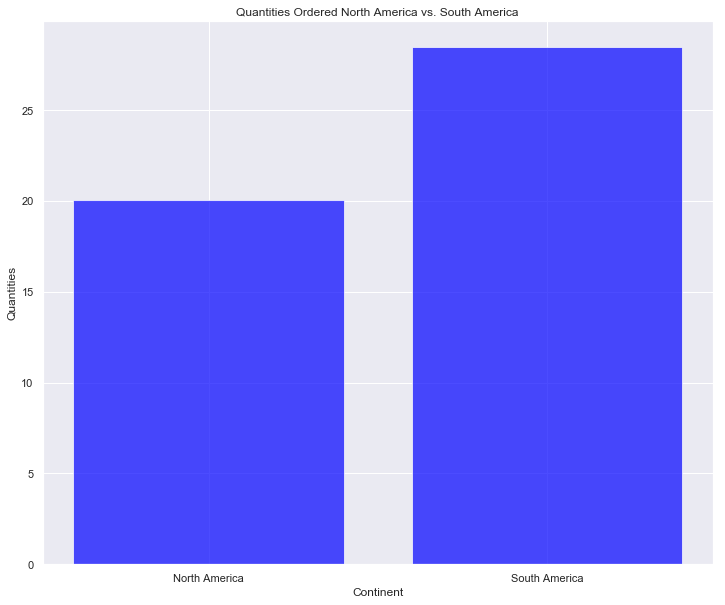

In [48]:


plt.figsize=(8,8)
mns = [northAmericaMU, southAmericaMU]
xs = ['North America', 'South America']

plt.bar(xs, mns, align = 'center', alpha = .70, color = 'blue')
plt.ylabel('Quantities')
plt.title('Quantities Ordered North America vs. South America')
plt.xlabel('Continent')


plt.show()